In [113]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [114]:
batch_size = 8
img_height = 224
img_width = 224

In [115]:
import pathlib
data_dir = "D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE"
data_dir = pathlib.Path(data_dir)

In [116]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)

In [117]:
image_count = len(list_ds)

In [118]:
for f in list_ds.take(5):
  print(f.numpy())

b'D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE\\13917\\7985.png'
b'D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE\\26789\\4419.png'
b'D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE\\26798\\14146.png'
b'D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE\\17666\\27940.png'
b'D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE\\13914\\25908.png'


In [119]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['13901' '13902' '13903' '13904' '13905' '13906' '13908' '13911' '13912'
 '13913' '13914' '13915' '13917' '13919' '13920' '13922' '13923' '13924'
 '13926' '13927' '13952' '13953' '13954' '13955' '13957' '13958' '13959'
 '13960' '13961' '13962' '13963' '13964' '13965' '13966' '13971' '13972'
 '13973' '13974' '13976' '13977' '13978' '13979' '13980' '13981' '13983'
 '13986' '13988' '13989' '17643' '17648' '17649' '17650' '17653' '17654'
 '17656' '17657' '17658' '17659' '17660' '17662' '17664' '17666' '17667'
 '17669' '17670' '17673' '17674' '17675' '18828' '18829' '18830' '18831'
 '18835' '18836' '18837' '18838' '18839' '18840' '18841' '18843' '18844'
 '18845' '18846' '18847' '18848' '18849' '18851' '18852' '19667' '19669'
 '19670' '19672' '19673' '19674' '19675' '19676' '19677' '19678' '19679'
 '19681' '19682' '19683' '19684' '19685' '19687' '19688' '19690' '19691'
 '19692' '19693' '19694' '19695' '19698' '19700' '26786' '26787' '26788'
 '26789' '26790' '26791' '26792' '26793' '26794' '2

In [120]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [121]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

24006
6001


In [122]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [123]:
def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, img

In [124]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [48]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [125]:
import matplotlib.pyplot as plt
image_batch = next(iter(train_ds))

IndexError: tuple index out of range

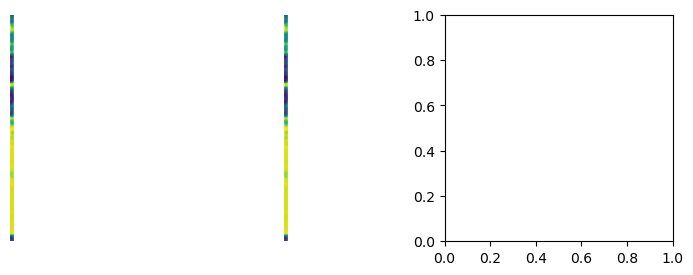

In [126]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i][0].numpy().astype("uint8"))
  plt.axis("off")

In [63]:
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1)
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.2)), # crop images from each side by 0 to 20% (randomly chosen)
    iaa.Sometimes(
        0.4,
        iaa.GaussianBlur(sigma=(0, 3))
    ),
    iaa.SaltAndPepper(p=(0,0.1), per_channel=True),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Affine(
        rotate=(-90, 90),
    )
], random_order=True) # apply augmenters in random order

In [127]:
from tensorflow.keras import layers
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [128]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [129]:
batch_size = 8
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x,y : (resize_and_rescale(x),y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x,y : (data_augmentation(x),y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [130]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

In [131]:
import sys
sys.path.insert(0, "D:\ISEN\M1\Projet M1\KimiaNet\Scripts")
import KimiaNet_AutoEncoder as Kn

In [132]:
autoencoder = Kn.KimiaNetAutoencoder()

In [133]:
autoencoder.compile()

In [ ]:
autoencoder.model.summary()

In [ ]:
autoencoder.freeze_encoder()

In [134]:
epochs=5
history = autoencoder.model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
 972/3001 [========>.....................] - ETA: 5:27 - loss: 19655.3770


KeyboardInterrupt



In [137]:
loss, acc = autoencoder.model.evaluate(train_ds)
print("Accuracy", acc)

3001/3001 [==============================] - 155s 51ms/step - loss: 18919.1348


TypeError: cannot unpack non-iterable float object